# Project 5

## Notebook Maintenance

Letizia Pichon

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.pipeline import *
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import *
from sklearn.compose import (ColumnTransformer,
                             TransformedTargetRegressor,
                             make_column_transformer)
from sklearn.metrics.cluster import adjusted_rand_score
from datetime import date
from dateutil.relativedelta import relativedelta
from dateutil import rrule
import datetime

%load_ext pycodestyle_magic
%pycodestyle_on

In [9]:
class MaintenanceAnalysis():
    def __init__(self, delta_t0=5):
        self.delta_t0 = delta_t0

    def create_basique_df(self):
        customers = pd.read_csv('data/olist_customers_dataset.csv')
        sellers = pd.read_csv('data/olist_sellers_dataset.csv')

        products = pd.read_csv('data/olist_products_dataset.csv')
        product_category = pd.read_csv('data/',
                                       'product_category_name_translation.csv')

        orders = pd.read_csv('data/olist_orders_dataset.csv')
        order_items = pd.read_csv('data/olist_order_items_dataset.csv')
        order_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')

        payments = pd.read_csv('data/olist_order_payments_dataset.csv')

        df = customers.merge(orders, on='customer_id', how='inner')\
                      .merge(order_items, on='order_id', how='inner')\
                      .merge(order_reviews, on='order_id', how='inner')\
                      .merge(products, on='product_id', how='inner')\
                      .merge(product_category, on='product_category_name',
                             how='inner')\
                      .merge(payments, on='order_id', how='left')\
                      .merge(sellers, on='seller_id', how='left')

        columns_to_keep = [
            'product_category_name_english',
            'order_status',
            'order_purchase_timestamp',
            'price',
            'freight_value',
            'customer_id',
            'customer_unique_id',
            'payment_type',
            'product_id',
            'customer_state',
            'seller_state',
            'review_comment_message',
            'review_score',
            "order_delivered_customer_date",
            "order_estimated_delivery_date"
        ]

        df = df[columns_to_keep]
        df = df[df['order_status'] == 'delivered']
        df['order_purchase_timestamp'] = pd.to_datetime(
            df['order_purchase_timestamp'])

        datetime_cols = ["order_purchase_timestamp",
                         "order_delivered_customer_date",
                         "order_estimated_delivery_date"]
        for col in datetime_cols:
            df[col] = df[col].astype('datetime64[ns]')

        df['product_category'] = np.where(
            (df['product_category_name_english'].str
             .contains("fashio|luggage|watch") == True),
            'fashion',
            np.where(
            (df['product_category_name_english'].str
             .contains("health|beauty|perfum") == True),
             'health_beauty',
            np.where((df['product_category_name_english'].str
                      .contains("toy|baby|diaper") == True),
                      'baby',
           np.where((df['product_category_name_english'].str
                     .contains("book|cd|dvd|media|music") == True),
                     'media',
           np.where((df['product_category_name_english'].str
                     .contains("grocer|food|drink") == True), 
                     'grocery',
           np.where((df['product_category_name_english'].str
                     .contains("phon|compu|tablet|electro|consol") == True), 
                     'technology',
           np.where((df['product_category_name_english'].str
                     .contains("home|furnitur|garden|bath|house|applianc|flow|cuisine") == True), 
                     'home_furniture',
           np.where((df['product_category_name_english'].str.contains("sport")==True),
                     'sport',
                     'other'))))))))
        return df
    
    def create_df_clustering(self, df, date_filter):
        df = df[df['order_purchase_timestamp'] <= date_filter]
        
        # Create rfm df 
        df_rfm = df.groupby('customer_unique_id').agg({
                    'order_purchase_timestamp': lambda x: (date_filter - x.max()).days,
                    'customer_id':'count',
                    'price': 'mean', 
                    'freight_value' : 'mean'}).reset_index()
        
        df_rfm = df_rfm.rename(columns={'order_purchase_timestamp': 'recency', 
                               'customer_id': 'frequency', 
                               'price': 'monetary'})
        df_rfm['freight_value'] = df_rfm.apply(lambda x: x['freight_value'] / x['monetary'] * 100,
                                               axis=1)
        df_rfm.drop(columns=['monetary'], inplace=True)
        # Create behavior df
        pc = df.groupby('customer_unique_id')['product_category'].agg(list).reset_index()
        pc['product_category'] = pc.apply(lambda x: list(dict.fromkeys(x['product_category'])), axis=1)
        pc['number_category'] = pc.apply(lambda x: len(x['product_category']), axis=1)
        
        pc = pc.merge(df.groupby('customer_unique_id')['product_id'].count().reset_index(), 
                      how='left', on='customer_unique_id')
        
        pc = pc.rename(columns={'product_id': 'number_products'})
        pc = pc.drop(columns=['product_category'])
        
        df = df.sort_values('order_purchase_timestamp', ascending=False)
        pay = df.groupby('customer_unique_id').agg({'payment_type':'first'}).reset_index()

        df_behavior = pay.merge(pc, how='inner', on='customer_unique_id')

        # Create geo df
        df['customer_seller_same_state'] = df.apply(lambda x:
                                                    1 if x['customer_state'] == x['seller_state'] else(0),
                                                    axis=1)
        df_geo = df.groupby('customer_unique_id')['customer_seller_same_state'].first().reset_index()
        
        # Create satisfaction
        df['review_comment_message'].fillna('', inplace=True)
        df['len_comment'] = df.apply(lambda x: len(x['review_comment_message']), axis=1)
        
        satisfaction = df.groupby('customer_unique_id').agg({
            'review_score':'first',
            'review_comment_message': 'count', 
            'len_comment':'first'}).reset_index()
        satisfaction = satisfaction.rename(columns={'review_comment_message': 'review_number'})
        
        # Create time df
        df = df.sort_values('order_purchase_timestamp', ascending=False)
        df["delivery_time"] = (df.order_delivered_customer_date - df.order_purchase_timestamp)\
                      .dt.round('1d').dt.days
        df['delay_delivery'] = (df.order_delivered_customer_date - df.order_estimated_delivery_date)\
                                .dt.round('1d').dt.days
        purchase_time = df.groupby('customer_unique_id')[['delivery_time', 'delay_delivery']]\
                          .first().reset_index()
        
        merged_df = df_rfm.merge(df_geo, on='customer_unique_id')\
                          .merge(purchase_time, on='customer_unique_id')\
                          .merge(satisfaction, on='customer_unique_id')
        
        merged_df = merged_df[['customer_unique_id', 'review_score',
                               'recency', 'customer_seller_same_state']]
        #.merge(df_behavior, on='customer_unique_id')\
        #                  .merge(df_geo, on='customer_unique_id')\
        #                  .merge(purchase_time, on='customer_unique_id')
        
        return merged_df
    
    def preprocessig(self, X):    
        numeric_features = X.select_dtypes(include=[np.number]).columns
        numeric_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", MinMaxScaler())]
        )
        
        
        categorical_features = X.select_dtypes(include=["object"]).columns
        categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
                ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False)),
            ]
        )

        preprocessor = ColumnTransformer(
                            transformers=[
                                ("numeric", numeric_transformer,
                                 numeric_features),
                                ("categorical", categorical_transformer,
                                 categorical_features)
                            ]
                        )
        return preprocessor

    def train(self, X):
        preprocessor = self.preprocessig(X)
        args = {'init': 'random', 'max_iter': 150, 'n_clusters': 5, 'n_init': 5}
        pipe = Pipeline(steps=[("preprocessor", preprocessor),
                               ("cluster", KMeans(**args))])
        pipe.fit(X)
        
        return pipe

    def weeks_between(self, start_date, end_date):
        weeks = rrule.rrule(rrule.WEEKLY, dtstart=start_date, until=end_date)
        return weeks.count()
        
    def anlysis(self): 
        
        df = self.create_basique_df()
        categorical_features = df.select_dtypes(include=["object"]).columns
        df[categorical_features] = df.loc[:,categorical_features].astype(str)
        recent_date = df['order_purchase_timestamp'].max()

        t0 = recent_date - relativedelta(months= self.delta_t0)
        df0 = self.create_df_clustering(df, t0)
        X0 = df0.drop(columns=['customer_unique_id'])
        m0 = self.train(X0)
        
        results = []
        print(t0)
        for i in range(1, self.weeks_between(t0, recent_date) + 1):
            result = {}
            t_n = t0 + relativedelta(weeks=i)
            df_n = self.create_df_clustering(df, t_n)
            X_n = df_n.drop(columns=['customer_unique_id'])
            m_n = self.train(X_n)
            c_n_m_n = m_n.predict(X_n)
            c_n_m0 = m0.predict(X_n) 
            ari_score = adjusted_rand_score(c_n_m0, c_n_m_n)
            print(ari_score)
            result['time'] = t_n
            result['score'] = ari_score
            results.append(result)
        sns.set(rc = {'figure.figsize':(15,8)})
        data = pd.DataFrame(results)
        g = sns.lineplot(data=data, x="time", y="score")
        g.set(ylim=(0.6, 1))

ValueError: too many values to unpack (expected 3)

2018-03-29 15:00:37
0.9880924505561502
0.9820311248005671
0.9761729579832519
0.9614853422826467
0.9100594606922625
0.9471310231013421
0.9444301122789843
0.9309037890424546
0.8547187146033466
0.5979619502742957
0.8283893317274525
0.8639062380939482
0.8464330698568657
0.8366324461671434
0.7645151456003404
0.8276793408005008
0.8169260662210338
0.8152890511440553
0.8168147210436393
0.810672752437737
0.8476748756648752
0.830226792157975


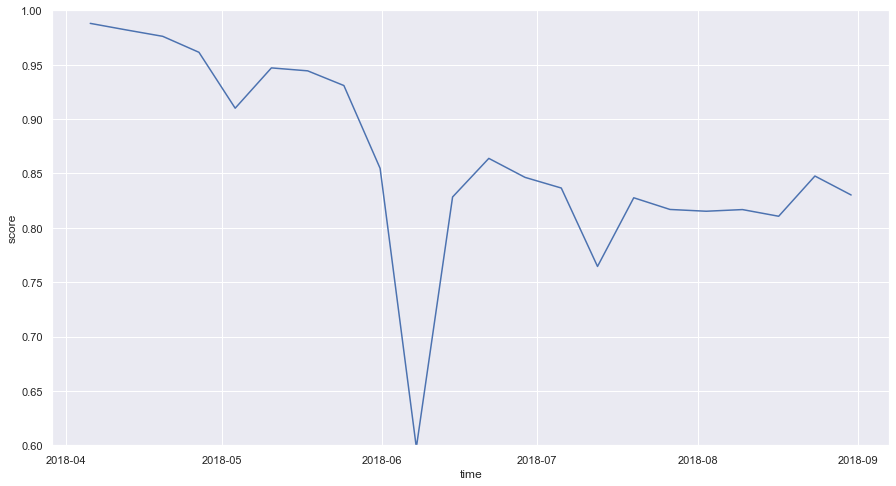

In [3]:
MaintenanceAnalysis().anlysis()